# BG/NBD Model

In this notebook we show how to fit a BG/NBD model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (not longer maintained). The model is presented in the paper: Fader, P. S., Hardie, B. G., & Lee, K. L. (2005). [“Counting your customers” the easy way: An alternative to the Pareto/NBD model. Marketing science, 24(2), 275-284.](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf)

We will use the `CDNOW` dataset (see lifetimes [quick-start](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)).

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import BetaGeoFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read Data

We use a dataset from the `lifetimes` package.

In [2]:
data_path = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/datasets/clv_quickstart.csv"

df = pd.read_csv(data_path)

df.head()

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


Recall from the `lifetimes` documentation the following definitions:

> - `frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
> - `T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

Next, we do a simple name change in one of the features:

In [3]:
data = df.reset_index().rename(columns={"index": "customer_id"})

## Model Specification

We do not want to go into the details of the model, but rather give a high level overview. The BG/NBD model is a probabilistic model that describes the buying behavior of a customer in the non-contractual setting. It is based on the following assumptions for each customer:

### Frequency Process

1. While active, the time between transactions is distributed exponential with transaction rate, i.e., 

    $$f(t_{j}|t_{j-1}; \lambda) = \lambda \exp(-\lambda (t_{j} - t_{j - 1})), \quad t_{j} \geq t_{j - 1} \geq 0$$ 

2. Heterogeneity in $\lambda$ follows a gamma distribution with pdf

    $$f(\lambda|r, \alpha) = \frac{\alpha^{r}\lambda^{r - 1}\exp(-\lambda \alpha)}{\Gamma(r)}, \quad \lambda  > 0$$

### Dropout Process

3. After any transaction, a customer becomes inactive with probability $p$.

4. Heterogeneity in $p$ follows a beta distribution with pdf

    $$f(p|a, b) = \frac{\Gamma(a + b)}{\Gamma(a) \Gamma(b)} p^{a - 1}(1 - p)^{b - 1}, \quad 0 \leq p \leq 1$$

5. The transaction rate $\lambda$ and the dropout probability $p$ vary independently across customers.

Instead of estimated each parameter for each specific customer, we estimate the parameters for a randomly chosen customer, i.e. we work with the expected values of the parameters. Hence, we are interesting in finding the posterior distribution of the parameters $r$, $\alpha$, $a$, and $b$.

## Model Fitting

Estimating such parameters is very easy in PyMC-Marketing. We instantiate the model is a similar way:

In [4]:
model_mcmc = clv.BetaGeoModel(data=data)

We can *build* the model so that we can see the model specification:

In [5]:
model_mcmc.build_model()
print(model_mcmc)

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))


We can now fit the model. The default sampler in PyMC-Marketing is the No-U-Turn Sampler (NUTS). We use the default $4$ chains and $1000$ draws per chain.

```{note}
It is not necessary to build the model before fitting it. We can fit the model directly.
```

In [ ]:
idata_mcmc = model_mcmc.fit()

In [7]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

We can look into the summary table:

In [8]:
model_mcmc.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.991,0.355,0.549,1.529,0.012,0.009,1333.0,1278.0,1.0
b,3.278,1.615,1.466,5.386,0.058,0.041,1254.0,1177.0,1.0
alpha,4.477,0.380,3.751,5.166,0.009,0.006,1764.0,1930.0,1.0
r,0.244,0.013,0.221,0.269,0.000,0.000,1839.0,1984.0,1.0


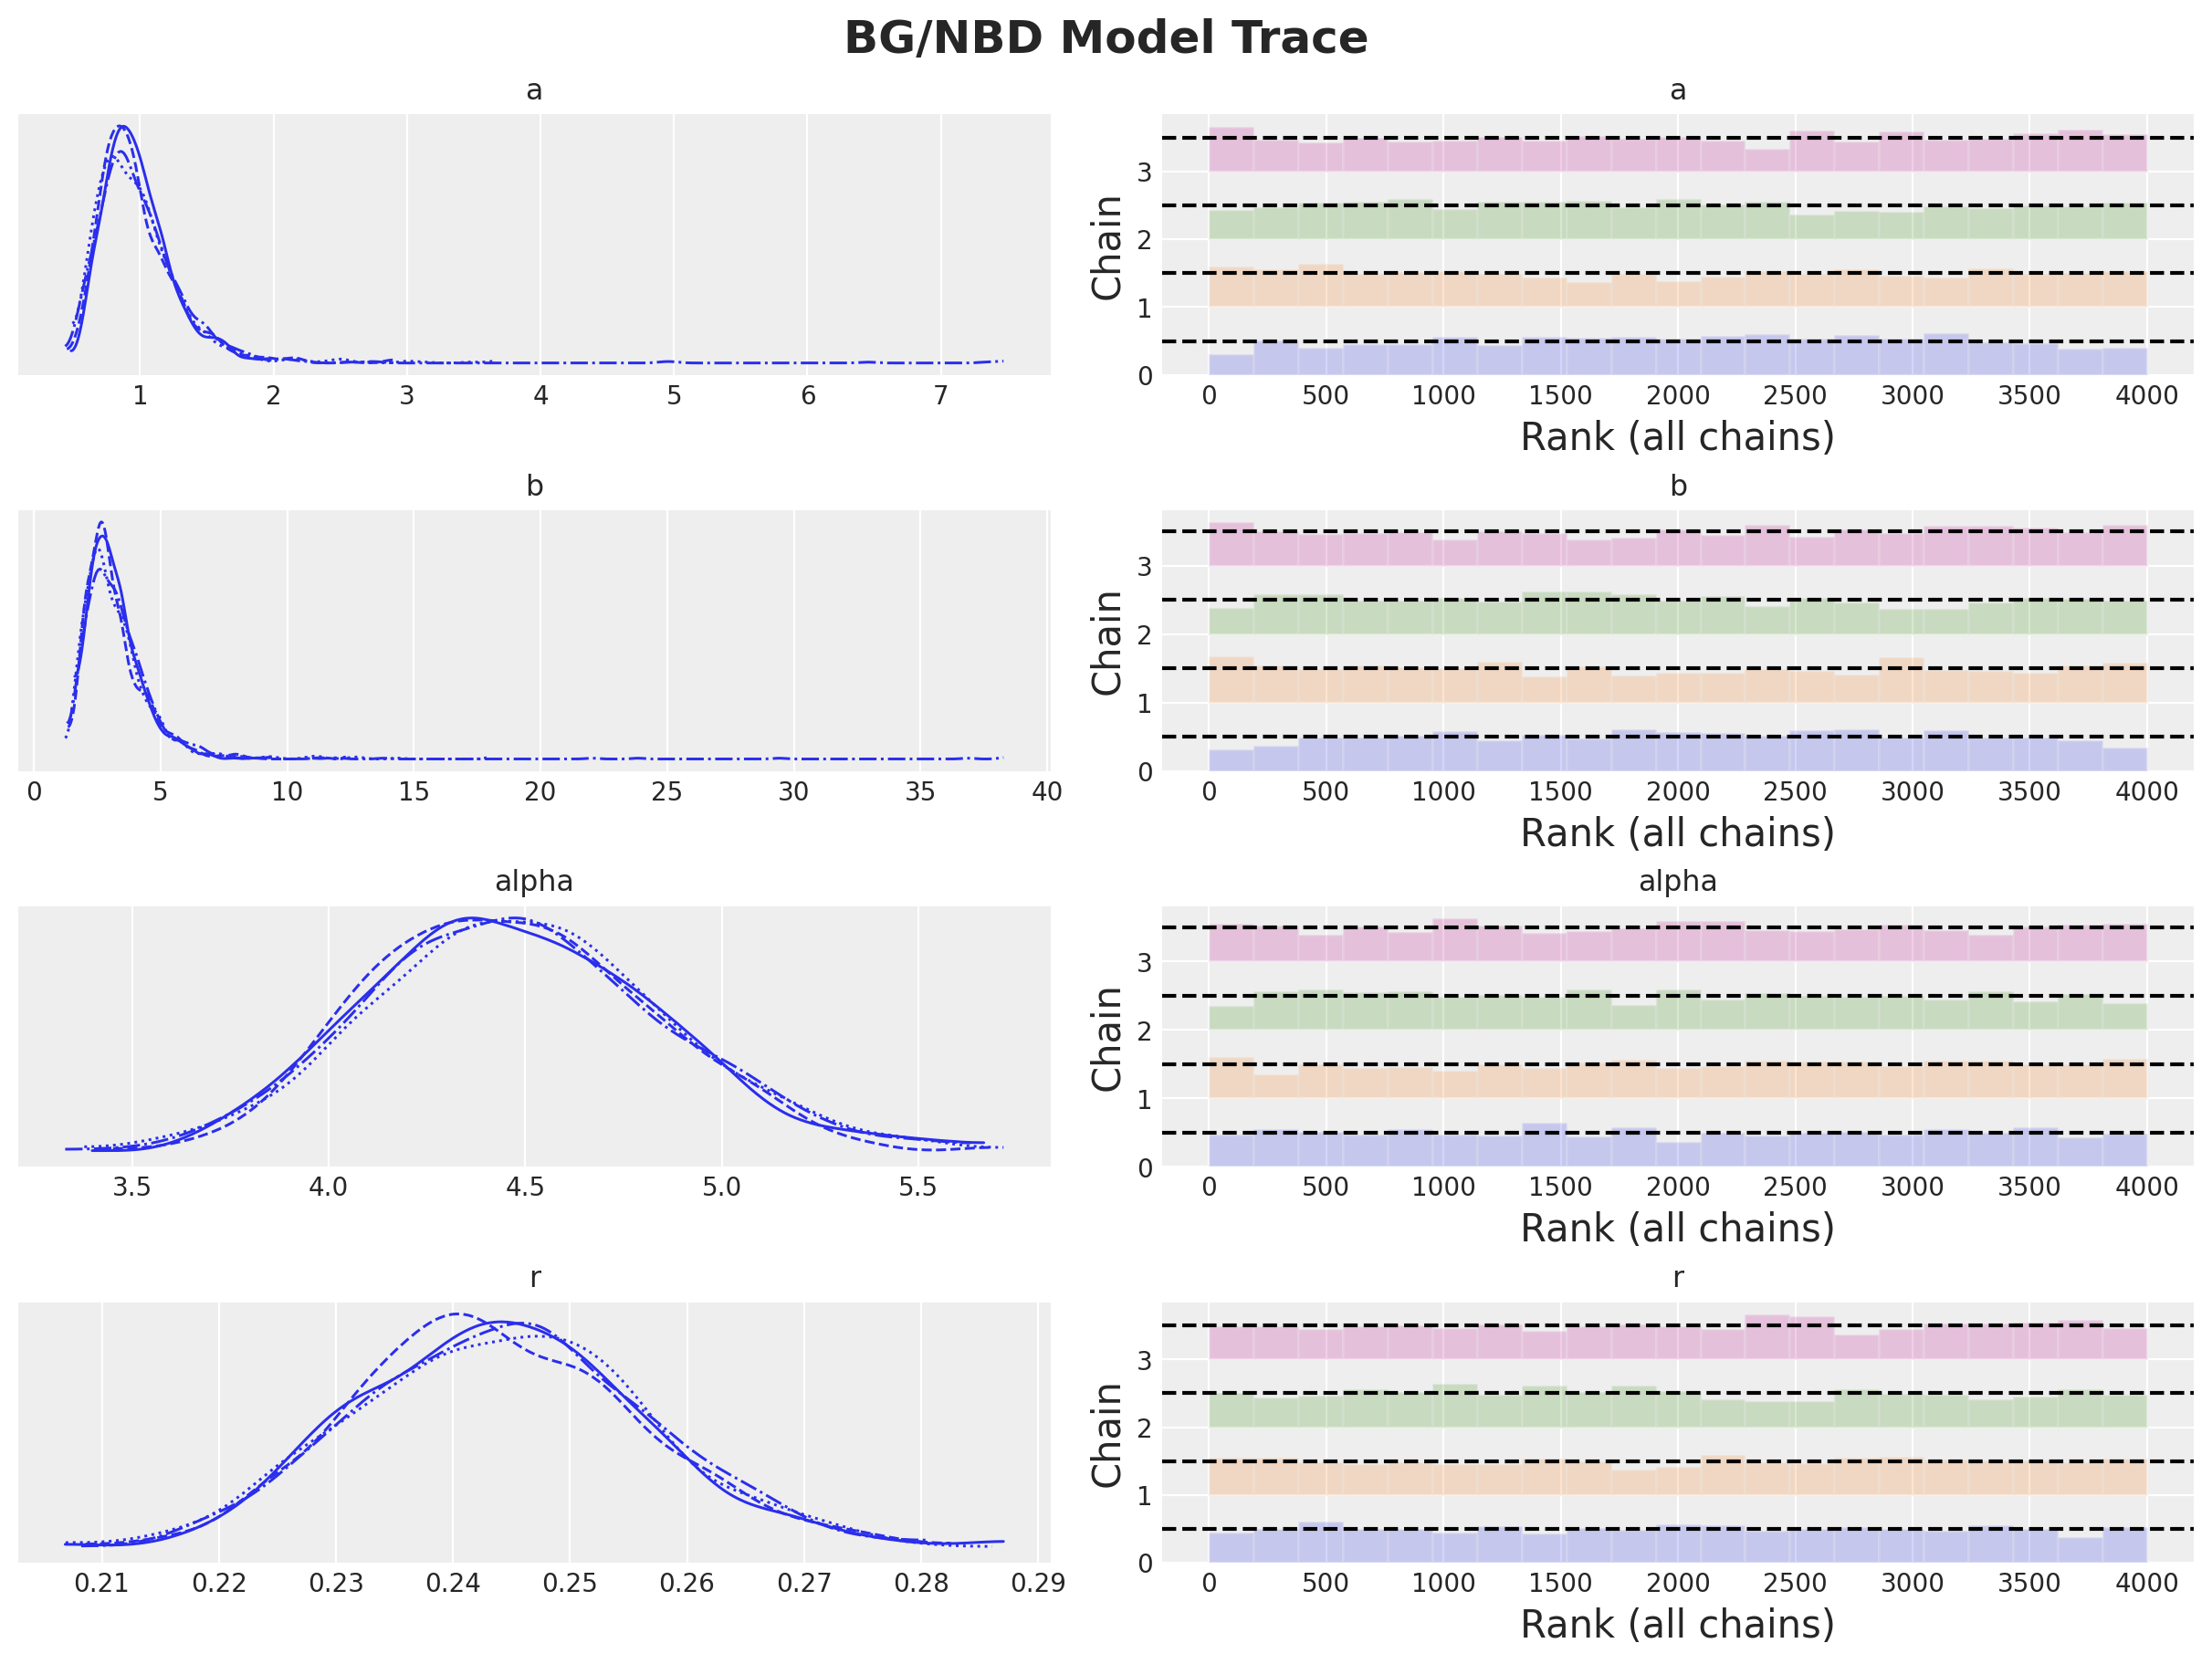

In [9]:
axes = az.plot_trace(
    data=model_mcmc.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("BG/NBD Model Trace", fontsize=18, fontweight="bold");

### Using MAP fit

`CLVModel`s, which includes `BetaGeoModel`, can provide the maximum a posteriori estimates using a numerical optimzer from `scipy.optimize`.

In [ ]:
model_map = clv.BetaGeoModel(data=data)
idata_map = model_map.fit(fit_method="map")

In [11]:
idata_map

Inference data with groups:
	> posterior
	> fit_data

This time we get point estimates for the parameters.

In [12]:
map_summary = model_map.fit_summary()

map_summary

a        0.793
b        2.426
alpha    4.414
r        0.243
Name: value, dtype: float64

## Comparing with the `lifetimes` package

For the sake of comparison, we also fit the model using the `lifetimes` package.

In [13]:
bgf = BetaGeoFitter()
bgf.fit(
    frequency=data["frequency"].values,
    recency=data["recency"].values,
    T=data["T"].values,
)

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


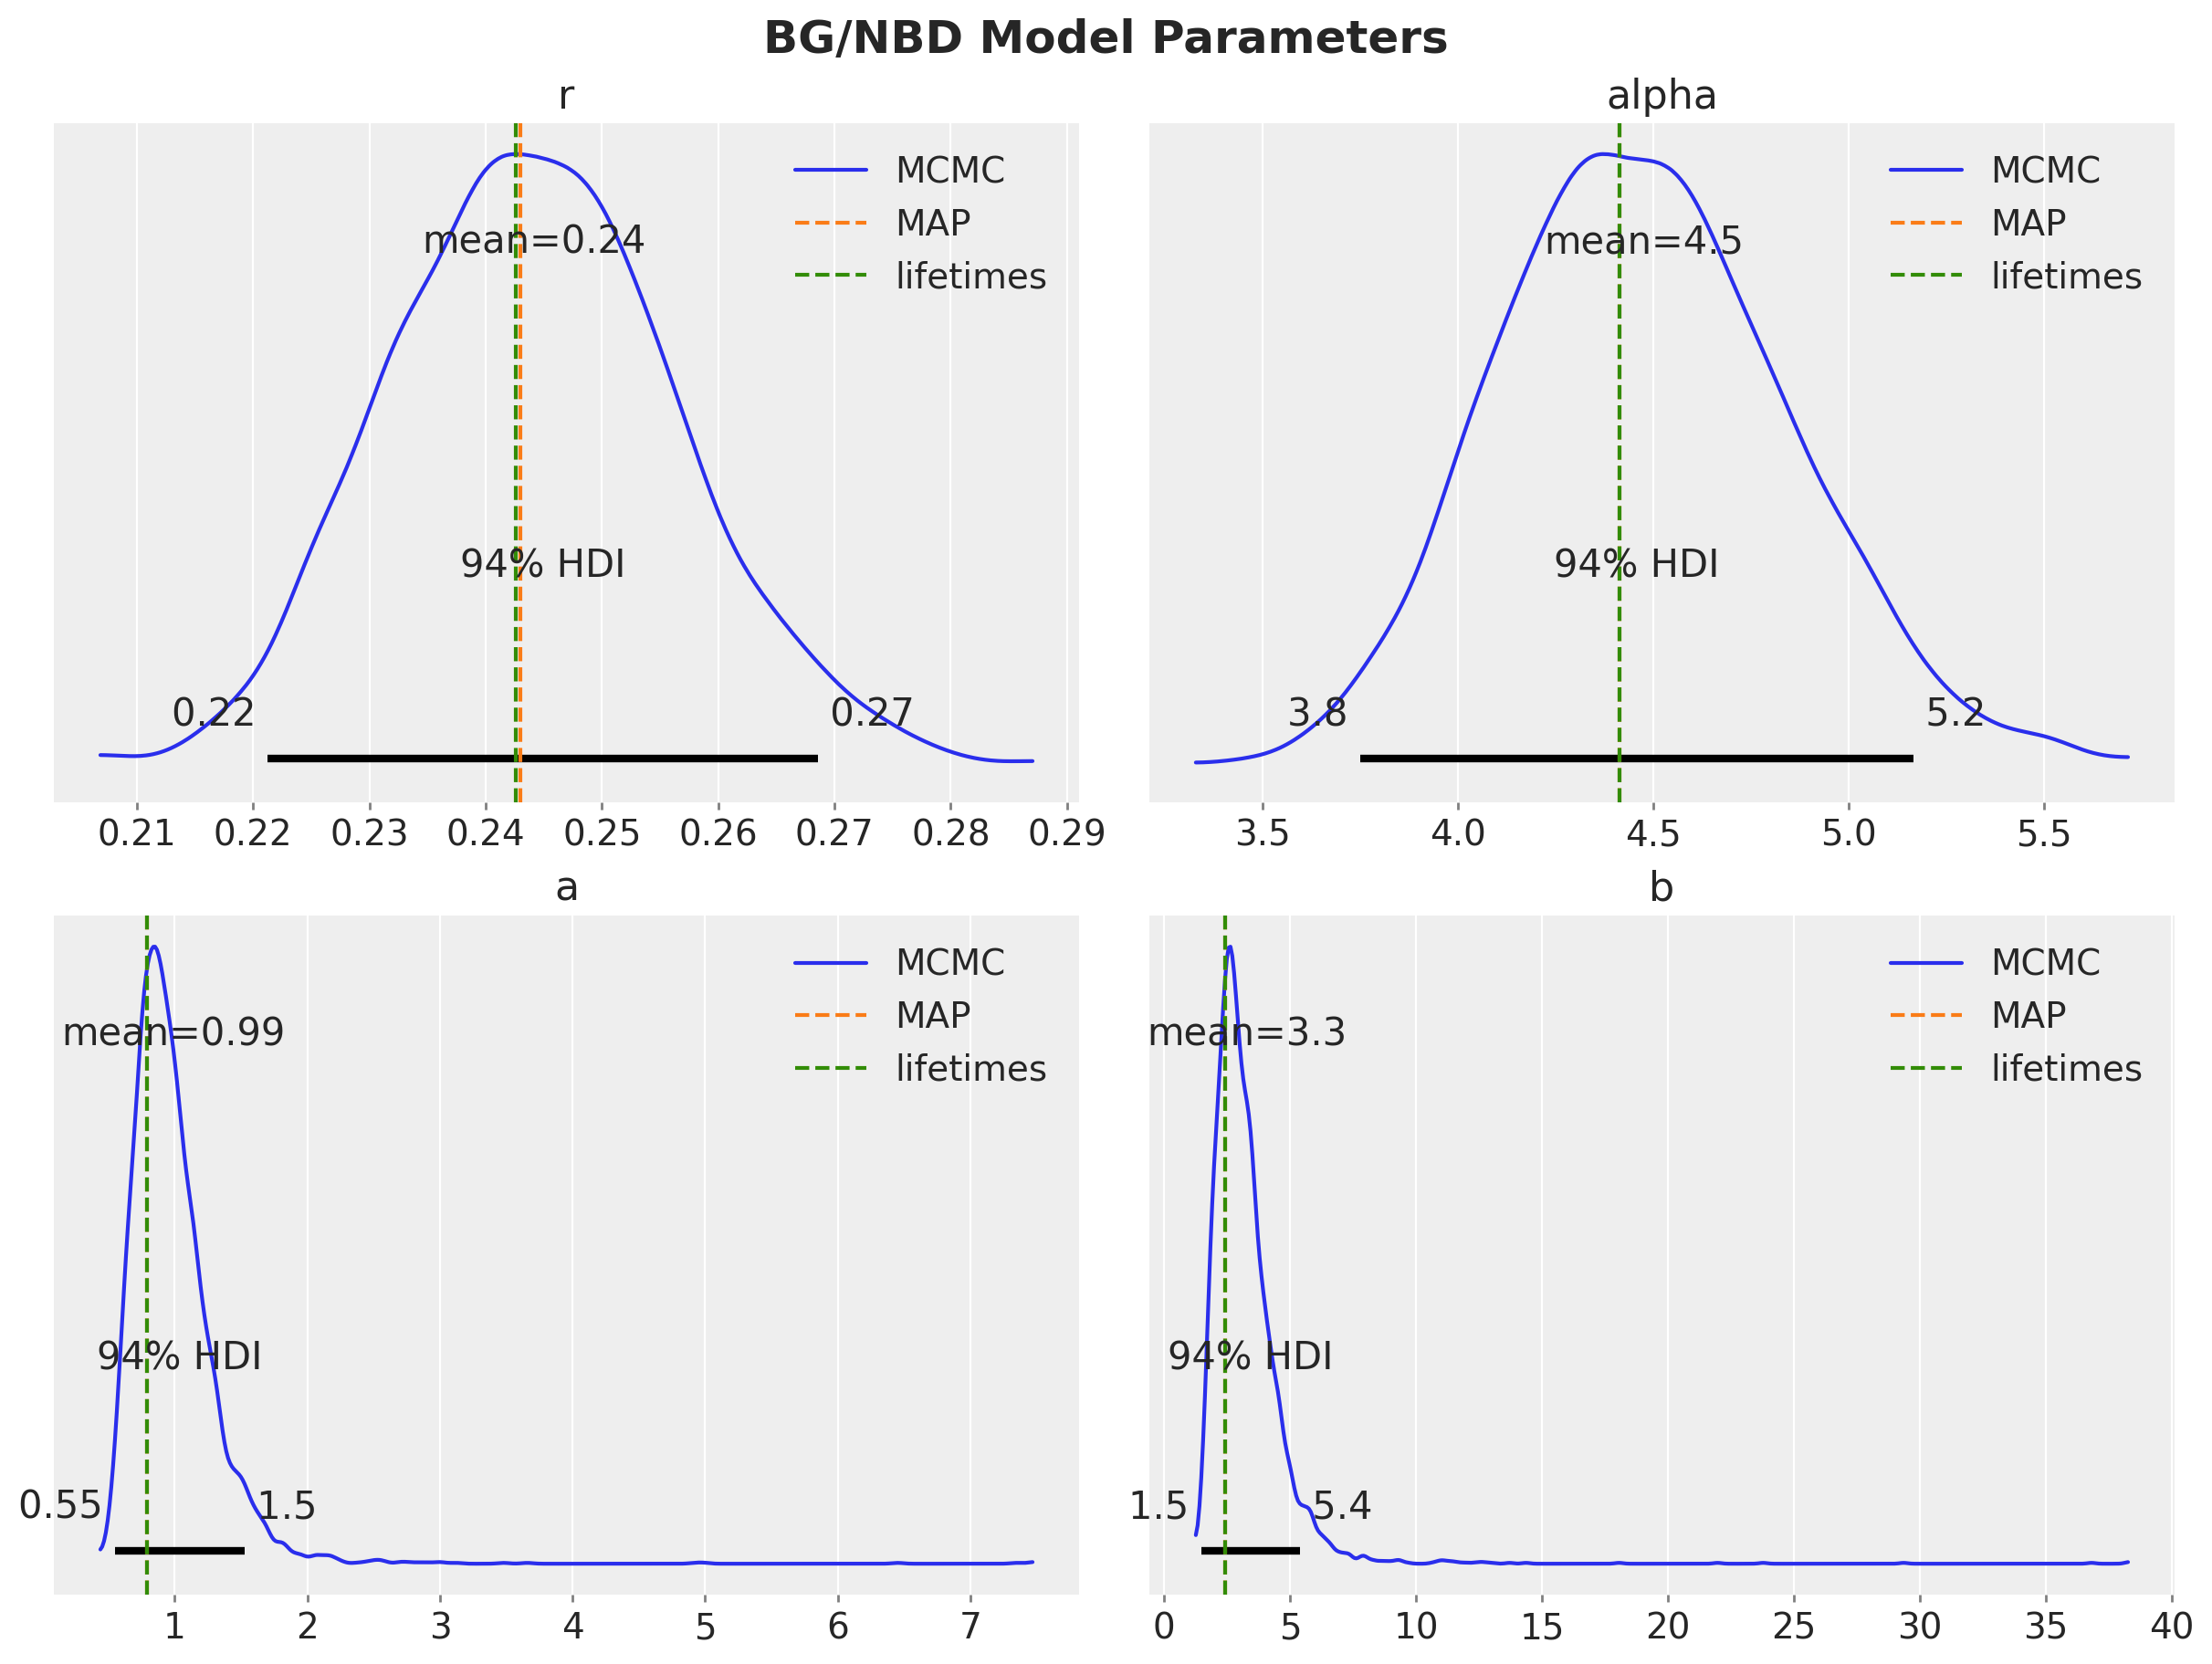

In [14]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        model_mcmc.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=bgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("BG/NBD Model Parameters", fontsize=18, fontweight="bold");

## Some Applications

Now that you have fitted the model, we can use it to make predictions. For example, we can predict the expected probability of a customer being alive as a function of time (steps). Here is a snippet of code to do that:

In [15]:
steps = 60

expected_probability_alive_steps = xr.concat(
    objs=[
        model_mcmc.expected_probability_alive(
            customer_id=data["customer_id"],
            frequency=data["frequency"],
            recency=data["recency"],
            T=data["T"] + t,  # add t days
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

Let us take a sample of users to visualize the probability of being alive as a function of time.

In [16]:
example_customer_ids = [1, 6, 11, 18, 1413, 1539]

data.query("customer_id.isin(@example_customer_ids)")

,customer_id,frequency,recency,T,monetary_value
1,1,1,1.71,38.86,11.77
6,6,1,5.00,38.86,11.77
11,11,0,0.00,38.86,0.00
18,18,3,28.29,38.71,25.08
1413,1413,4,16.86,31.57,92.42
1539,1539,0,0.00,30.86,0.00


Observe that the last two customers are *frequent buyers* as compared to the others.

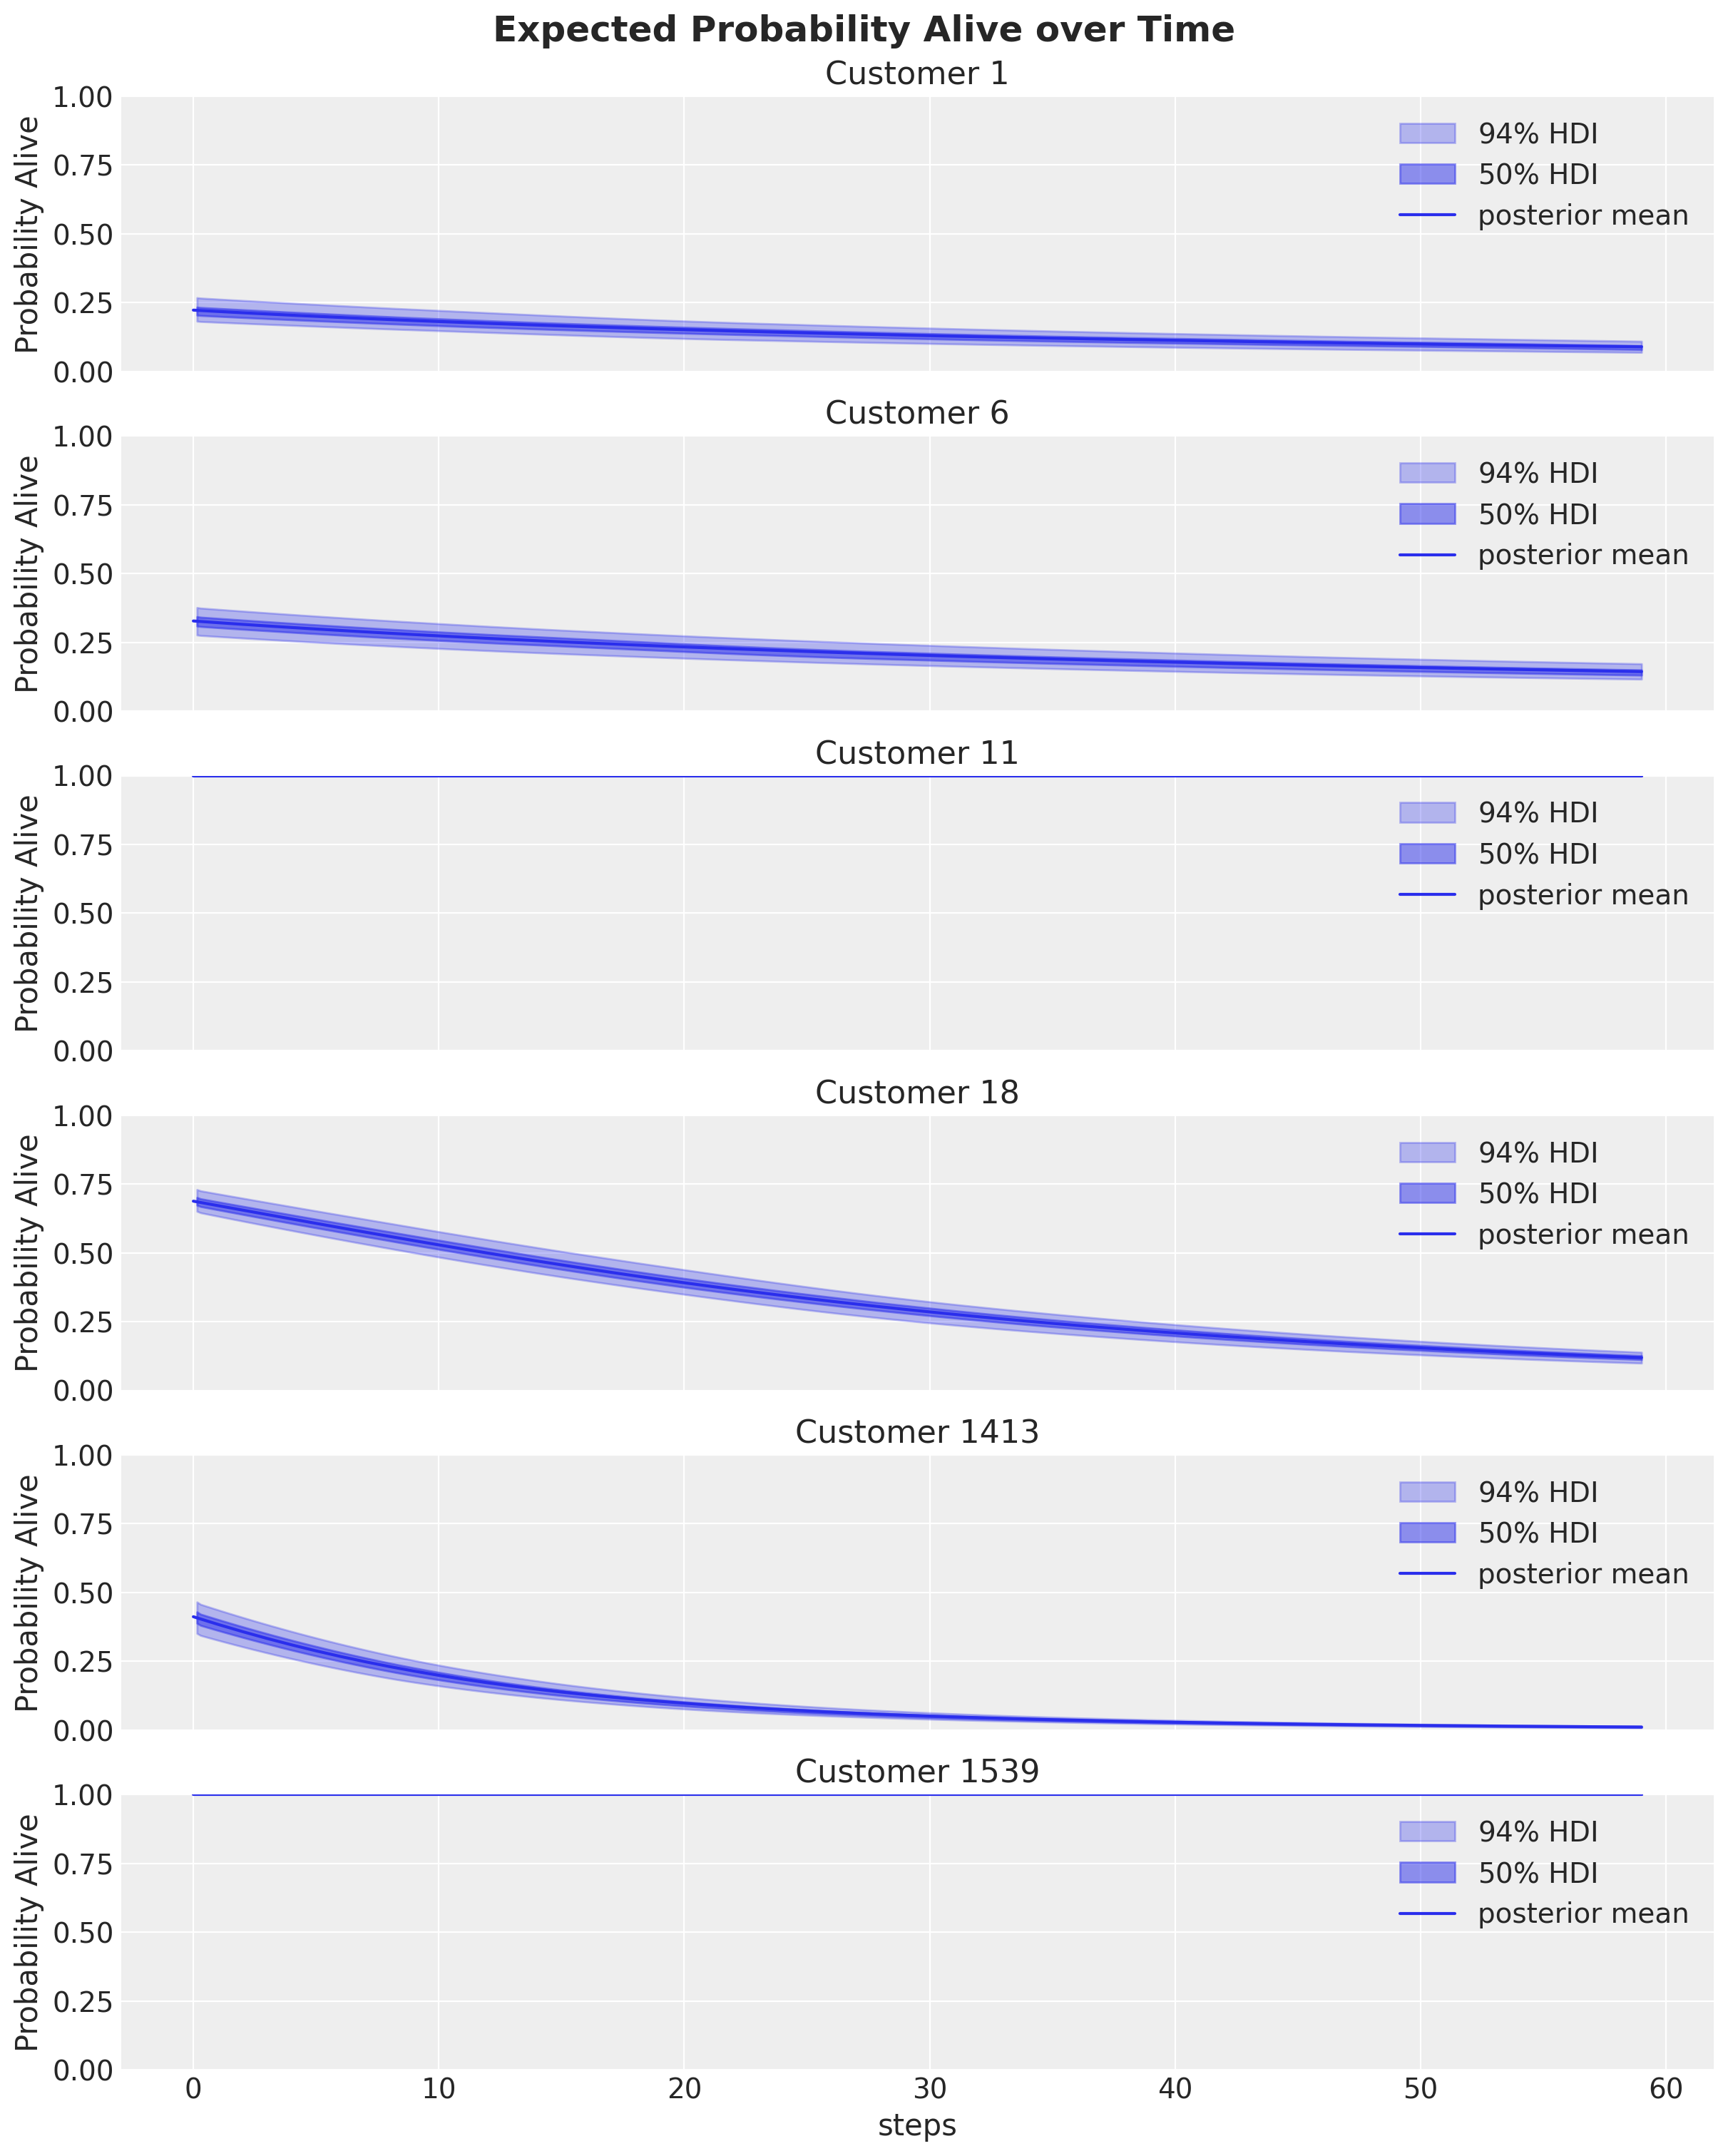

In [17]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="Probability Alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

```{tip}
Here are some general remarks:
- **It's important to remark these plots assume no future purchases.**
- The decay probability is not the same as it depends in the purchase history of the customer. 
- The probability of being alive is always decreasing as we are assuming there is no change in the other parameters. 
- These probabilities are always non-negative, as expected.
```

```{warning}
For the frequent buyers, the probability of being alive drops very fast as we are assuming no future purchases. It is very important ot keep this in mind when interpreting the results.
```

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Wed Apr 03 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pymc    : 5.11.0
pytensor: 2.18.6

arviz         : 0.17.1
pandas        : 2.2.1
pymc_marketing: 0.4.0
xarray        : 2024.2.0
matplotlib    : 3.8.3

Watermark: 2.4.3

